In [1]:
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from util import snana
from util.txtobj import txtobj

Text(0.5, 1.0, 'SNID = 630, $x_0$ = 2.08e-05, $x_1$ = 2.01, c = 0.070')

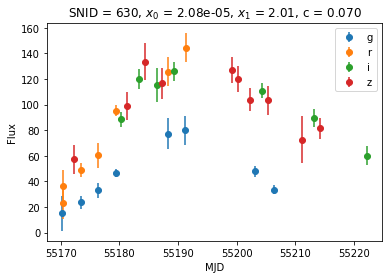

In [2]:
fr = txtobj('fitting/PS1MD.FITRES.TEXT',fitresheader=True)

lcfiles = glob.glob(os.path.expandvars('$SNDATA_ROOT/SIM/PS1MD/*DAT'))
sn = snana.SuperNova(lcfiles[10])
for f in sn.FILTERS:
    plt.errorbar(sn.MJD[sn.FLT == f],sn.FLUXCAL[sn.FLT == f],
                 yerr=sn.FLUXCALERR[sn.FLT == f],label=f,fmt='o')
plt.ylabel('Flux')
plt.xlabel('MJD')
plt.legend()

iSN = fr.CID == sn.SNID
plt.title('SNID = %s, $x_0$ = %8.2e, $x_1$ = %.2f, c = %.3f'%(
          sn.SNID,fr.x0[iSN],fr.x1[iSN],fr.c[iSN]))

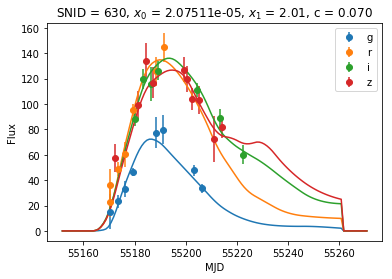

In [3]:
import sncosmo
from util import register
   
for f in sn.FILTERS:
    plt.errorbar(sn.MJD[sn.FLT == f],sn.FLUXCAL[sn.FLT == f],
                 yerr=sn.FLUXCALERR[sn.FLT == f],label=f,fmt='o')
plt.ylabel('Flux')
plt.xlabel('MJD')
plt.legend()

iSN = fr.CID == sn.SNID
plt.title('SNID = %s, $x_0$ = %8.5e, $x_1$ = %.2f, c = %.3f'%(
          sn.SNID,fr.x0[iSN],fr.x1[iSN],fr.c[iSN]))
    
import sncosmo
from util import register

dust = sncosmo.F99Dust()
dust.set(ebv=float(sn.MWEBV.split()[0])) # pretty ugly but whatever

model = sncosmo.Model(source='salt2',effects=[dust],effect_names=['mwebv'],effect_frames=['obs'])
# NOTE - SNANA SALT2 implementation has a 0.27 mag offset from sncosmo.
# this doesn't matter at all for most things like cosmology analyses,
# but certainly matters for making plots
model.set(z=fr.zHEL[iSN],t0=fr.PKMJD[iSN],
          x1=fr.x1[iSN],c=fr.c[iSN],x0=fr.x0[iSN]*10**(-0.4*(0.27)))

# register the filters to sncosmo using the kcor file.  sncosmo has
# pre-canned filter sets but it's best to be safe in a game where mmag
# offsets matter
mjd = np.arange(fr.PKMJD[iSN]-40,fr.PKMJD[iSN]+80,1)
register.from_kcor('kcor/kcor_PS1.fits')
for i,f in enumerate(sn.FILTERS):

    # careful about zpsys!
    salt2flux = model.bandflux(f, mjd, zp=27.5, zpsys='AB')
    plt.plot(mjd,salt2flux,color='C%i'%i)


### Making a Quick Hubble Diagram

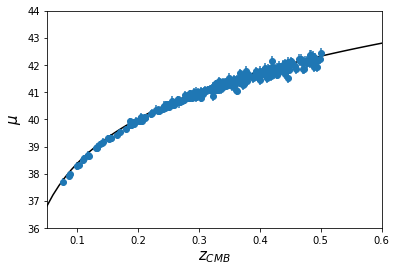

In [13]:
# import our baseline cosmological params for comparison
from astropy.cosmology import Planck15 as cosmo
from util import getmu

# gives the fitres object a "mu", "muerr" and "mures" attribute
fr = getmu.getmu(fr)
fr = getmu.mkcuts(fr)
iErr = fr.muerr < 0.2 # no crazy errors!

zrange = np.arange(0,1,0.01)
plt.plot(zrange,cosmo.distmod(zrange).value,color='k')
plt.errorbar(fr.zCMB[iErr],fr.mu[iErr],yerr=fr.muerr[iErr],fmt='o')
plt.xlabel('$z_{CMB}$',fontsize=15)
plt.ylabel('$\mu$',fontsize=15)
plt.xlim([0.05,0.6])
plt.ylim([36,44])